In [67]:
!pip install xgboost

In [68]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import numpy as np
import torch
from torchvision import transforms, models
from torchinfo import summary
from PIL import Image
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from glob import glob
import timm
from xgboost import XGBClassifier

### Build DL model

In [69]:
from utils.helper import get_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the pre-trained model
model_name = "convnext"
FE = get_model(model_name, num_classes=4, include_top=False)
FE.eval()
## REMOVE LAST CLASSIFIER LAYER
summary(FE, input_size=(1, 3, 224, 224))


Layer (type:depth-idx)                             Output Shape              Param #
ConvNeXt                                           [1, 768]                  --
├─ConvNeXt: 1-1                                    [1, 768]                  --
│    └─Sequential: 2-1                             [1, 768, 7, 7]            --
│    │    └─Conv2dNormActivation: 3-1              [1, 96, 56, 56]           4,896
│    │    └─Sequential: 3-2                        [1, 96, 56, 56]           237,888
│    │    └─Sequential: 3-3                        [1, 192, 28, 28]          74,112
│    │    └─Sequential: 3-4                        [1, 192, 28, 28]          918,144
│    │    └─Sequential: 3-5                        [1, 384, 14, 14]          295,680
│    │    └─Sequential: 3-6                        [1, 384, 14, 14]          32,451,840
│    │    └─Sequential: 3-7                        [1, 768, 7, 7]            1,181,184
│    │    └─Sequential: 3-8                        [1, 768, 7, 7]            1

### Use DL model to extract features

In [70]:
def extract_features(image_paths, model, target_size=(224, 224)):
    features = []
    labels = []
    transform = transforms.Compose([
        transforms.Resize(min(target_size)), 
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    with torch.no_grad():
        for img_path, label in image_paths:
            img = Image.open(img_path).convert('RGB')
            img_tensor = transform(img).unsqueeze(0).to(device)
            
            # Extract features
            feature = model(img_tensor)
            
            # Convert to numpy and flatten
            feature = feature.cpu().numpy().flatten()
            feature = feature.flatten() 

            features.append(feature)
            labels.append(label)

    return np.array(features), np.array(labels)

In [71]:
# versioning dataset
import wandb
config = {
    "extractor": model_name,
    "model": "svm",
}
run = wandb.init(
    project="hutech_mushroom",
    job_type="train",
    config=config,
)

artifact_data = run.use_artifact('beehappy2554-bosch-global/hutech_mushroom/hutech-dataset:latest', type='dataset')
artifact_data_dir = artifact_data.download()

wandb:   1247 of 1247 files downloaded.  


In [72]:
data = ["train", "val", "test"]
labels = [0, 1, 2, 3]

data = ["base"]
artifact_data_dir = ".."

def load_image_paths(folder, label):
    return [(img_path, label) for img_path in glob(os.path.join(folder, "*.jpg"))]

train_data = []
val_data = []
test_data = []

for l in labels:
    for d in data:
        folder = os.path.join(artifact_data_dir, d, str(l))
        image_paths = load_image_paths(folder, l)
        if d == "train":
            train_data.extend(image_paths)
        elif d == "val":
            val_data.extend(image_paths)
        elif d == "test":
            test_data.extend(image_paths)
        else:
            train_data.extend(image_paths)


print("Processing train data...")
X_train, y_train = extract_features(train_data, FE)
print("Processing validation data...")
X_val, y_val = extract_features(val_data, FE)
print("Processing test data...")
X_test, y_test = extract_features(test_data, FE)

Processing train data...
Processing validation data...
Processing test data...


# combine val and train data

In [73]:
# X_train = np.concatenate((X_train, X_val))
# y_train = np.concatenate((y_train, y_val))
# print(X_train.shape)
# print(y_train.shape)

# run base model

In [74]:
C = 1
gamma = "scale"
kernel = "rbf"

model = SVC(C=C, gamma=gamma, kernel=kernel)
# model = SVC(C=0.1, gamma='scale', kernel='linear')
# model = SVC(C=1, gamma="auto", kernel="rbf")
model.fit(X_train, y_train)

# model = XGBClassifier()
# model.fit(X_train, y_train)

SVC(C=1)

## Optimize model

In [75]:
param_grid = {
    "C": [0.1, 0.5, 1, 2, 10],
    "gamma": ["scale", "auto", 0.1, 1, 5],
    "kernel": ["linear", "rbf"]
}

# param_grid = {
#     "booster": ["gbtree"],
#     "n_estimators": [100, 200],
#     "max_depth": [5, 7, 10],
#     "learning_rate": [0.01, 0.1, 0.2],
#     "lambda": [0, 1, 2, 5, 10],
#     "alpha": [0, 1, 2, 5, 10],
#     "subsample": [0.5, 0.7, 1],
#     "min_child_weight": [1, 3, 5],

# }

In [76]:
from sklearn.model_selection import GridSearchCV
# model = XGBClassifier()
grid_search = GridSearchCV(model, param_grid, cv=5)     
grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best Score: 0.9533333333333334


In [77]:
# try the best model
C = grid_search.best_params_["C"]
gamma = grid_search.best_params_["gamma"]
kernel = grid_search.best_params_["kernel"]

print(C, gamma, kernel)
model = SVC(C=C, gamma=gamma, kernel=kernel)
# model = SVC(C=0.1, gamma='scale', kernel='linear')
# model = SVC(C=1, gamma="auto", kernel="rbf")
model.fit(X_train, y_train)

0.1 scale linear


SVC(C=0.1, kernel='linear')

- save model

In [78]:
import joblib
model_path = "../models"
os.makedirs(model_path, exist_ok=True)
# Save the model
model_path = os.path.join(model_path, "svm_model.pkl")
joblib.dump(model, model_path)

['../models/svm_model.pkl']

### Inference

In [79]:
import cv2

def wrapper_model(img_path, feature_extractor, model):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    with torch.no_grad():

        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)
        
        feature = feature_extractor(img_tensor)
        feature = feature.cpu().numpy().flatten()
        feature = feature.flatten() 
        prediction = model.predict(feature.reshape(1, -1))
    
    return prediction.squeeze()

1


Text(0.5, 1.0, 'nấm bào ngư')

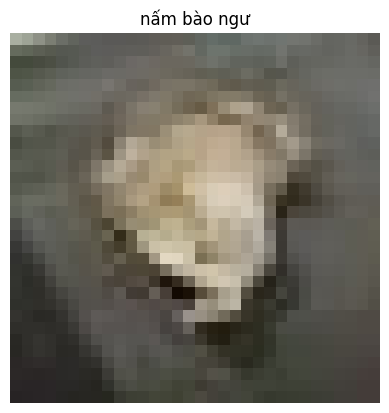

In [80]:
img_path = os.path.join("../final_test","003.jpg")
labels_names = ["nấm mỡ", "nấm bào ngư", "nấm đùi gà", "nấm linh chi trắng"] 

result = wrapper_model(img_path, FE, model)
print(result)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.title(labels_names[result])

### Plot test results

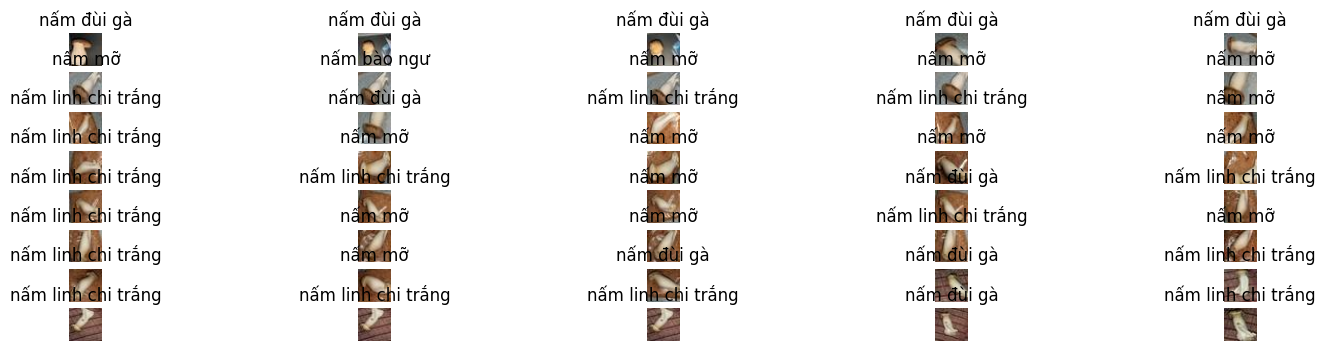

In [81]:
path = "../final_test"

images = glob(os.path.join(path, "*.jpg"))
fig, axes = plt.subplots(8, 5, figsize=(18, 4))
for i, img_path in enumerate(images[50:90]):
    result = wrapper_model(img_path, FE, model)
    result_text = labels_names[result]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i // 5, i % 5].imshow(img)
    axes[i // 5, i % 5].axis("off")
    axes[i // 5, i % 5].set_title(result_text)

# final test kaggle

In [82]:
import time
import pandas as pd
import glob
results = []


test_dir = "../final_test"
image_files = glob.glob(os.path.join(test_dir, "*.*"))

table = wandb.Table(columns=["image", "class"])

classes = {
    0: "nấm mỡ",
    1: "nấm bào ngư",
    2: "nấm đùi gà",
    3: "nấm linh chi trắng",
}
start = time.time()

for image_path in image_files:
    image_id = os.path.basename(image_path).replace(".jpg", "")
    pred_class_idx = wrapper_model(image_path, FE, model)
    print(f"Predicting {image_path} as class {pred_class_idx}")
    results.append({"id": image_id, "type": pred_class_idx}) 
    table.add_data(wandb.Image(image_path), labels_names[pred_class_idx])

end = time.time()
print("Time taken for prediction:", end - start)
# Create a DataFrame from the results and export to CSV
df = pd.DataFrame(results)
df.to_csv("kaggle_submission.csv", index=False)
print("Submission file saved as kaggle_submission.csv")

Predicting ../final_test/001.jpg as class 1
Predicting ../final_test/002.jpg as class 1
Predicting ../final_test/003.jpg as class 1
Predicting ../final_test/004.jpg as class 1
Predicting ../final_test/005.jpg as class 1
Predicting ../final_test/006.jpg as class 1
Predicting ../final_test/007.jpg as class 1
Predicting ../final_test/008.jpg as class 1
Predicting ../final_test/009.jpg as class 1
Predicting ../final_test/010.jpg as class 1
Predicting ../final_test/011.jpg as class 1
Predicting ../final_test/012.jpg as class 1
Predicting ../final_test/013.jpg as class 1
Predicting ../final_test/014.jpg as class 1
Predicting ../final_test/015.jpg as class 1
Predicting ../final_test/016.jpg as class 1
Predicting ../final_test/017.jpg as class 1
Predicting ../final_test/018.jpg as class 1
Predicting ../final_test/019.jpg as class 1
Predicting ../final_test/020.jpg as class 1
Predicting ../final_test/021.jpg as class 1
Predicting ../final_test/022.jpg as class 1
Predicting ../final_test/023.jpg

In [83]:
count_0 = 0
count_1 = 0
count_2 = 0
count_3 = 0
for i in range(0, 50):
    if results[i]["type"] == 1:
        count_1 += 1
for i in range(50, 100):
    if results[i]["type"] == 2:
        count_2 += 1
for i in range(100, 150):
    if results[i]["type"] == 3:
        count_3 += 1
for i in range(150, 200):
    if results[i]["type"] == 0:
        count_0 += 1    
print("Count of class 1:", count_1)
print("Count of class 2:", count_2)
print("Count of class 3:", count_3)
print("Count of class 0:", count_0)
print("Accuracy:", (count_0 + count_1 + count_2 + count_3) / 200)

Count of class 1: 49
Count of class 2: 17
Count of class 3: 50
Count of class 0: 49
Accuracy: 0.825


- val set

In [84]:
# y_pred = model.predict(X_val)

In [85]:
# labels_names = ["nấm mỡ", "nấm bào ngư", "nấm đùi gà", "nấm linh chi trắng"] 

# accuracy = accuracy_score(y_val, y_pred)
# report = classification_report(y_val, y_pred, target_names=labels_names, zero_division=0)
# conf_matrix = confusion_matrix(y_val, y_pred)

# print(f"Accuracy: {accuracy:.4f}")
# print("\nClassification Report:\n", report)
# plt.figure(figsize=(6, 5))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
#             xticklabels=labels_names, yticklabels=labels_names)

# plt.title("Confusion Matrix")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")

# plt.show()

- test set

In [86]:
# y_pred = model.predict(X_test)

In [87]:
# labels_names = ["nấm mỡ", "nấm bào ngư", "nấm đùi gà", "nấm linh chi trắng"] 

# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred, target_names=labels_names, zero_division=0)
# conf_matrix = confusion_matrix(y_test, y_pred)

# print(f"Accuracy: {accuracy:.4f}")
# print("\nClassification Report:\n", report)
# plt.figure(figsize=(6, 5))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
#             xticklabels=labels_names, yticklabels=labels_names)

# plt.title("Confusion Matrix")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")

# plt.show()

# Test on final_test